In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Setting dataset directory

In [2]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir+'/Potato/Training/')
print(dataset_dir)

c:\Users\aryaj\OneDrive\Desktop\project 6\final_code\Potato\Training


### Setting some global variables

In [3]:
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 10

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True) 

Found 5819 files belonging to 3 classes.


In [5]:
class_name = dataset.class_names
class_name

['Early_Blight', 'Healthy', 'Late_Blight']

In [6]:
len(dataset)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


### Some sample images

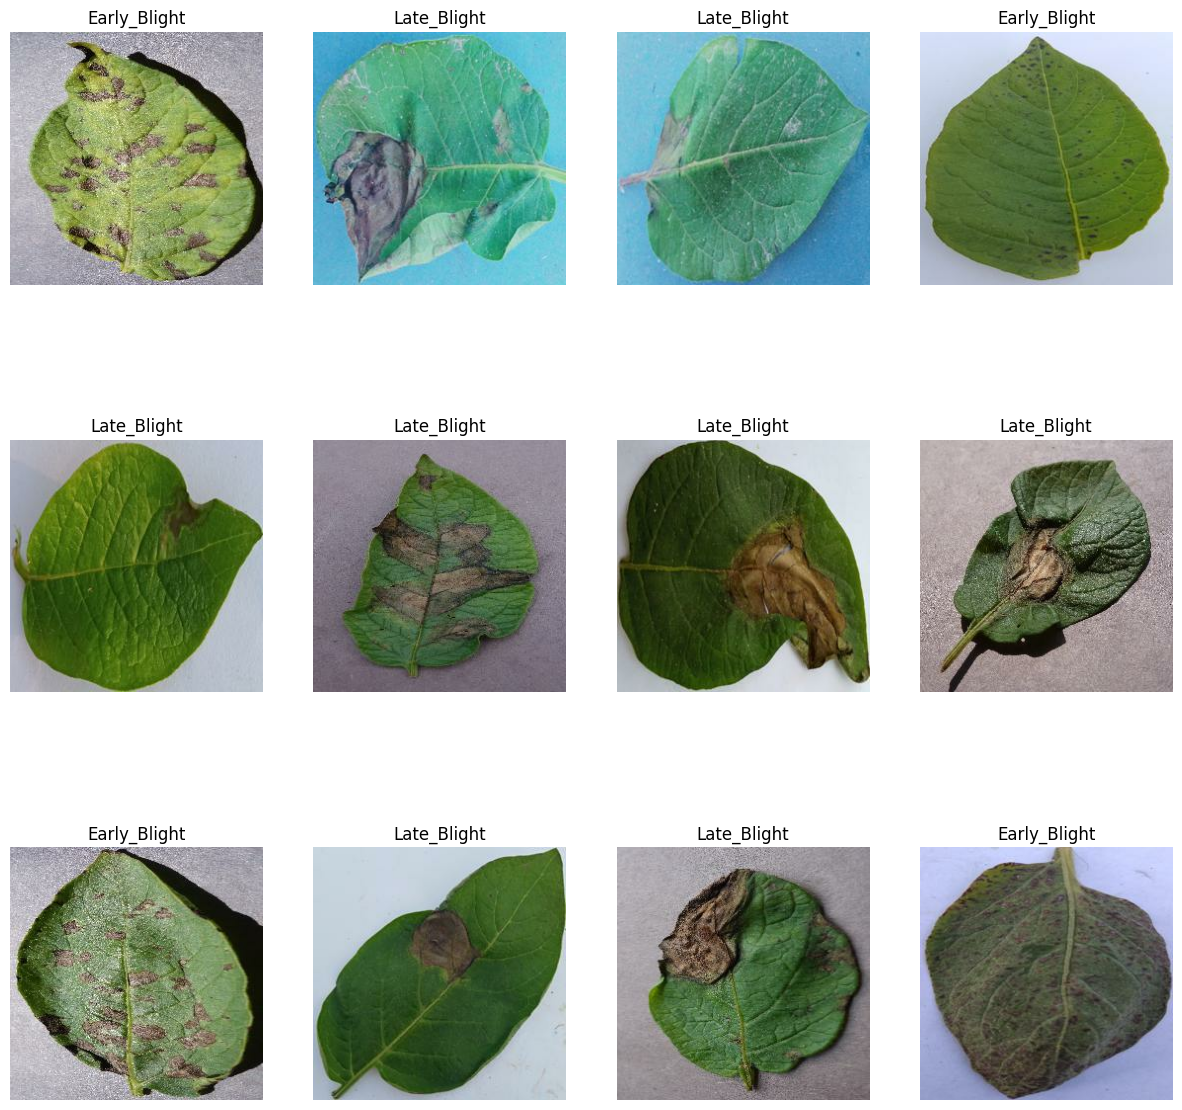

In [7]:
plt.figure(figsize = (15,15))
for image, label in dataset.take(1): 
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis("off")

### Splitting the dataset

In [8]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_data, val_data, test_data = split_dataset(dataset)

In [10]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :182 
Batch size of Training Data is :145
Batch size of Validation Data is :18 
Batch size of Testing Data is :19 


In [11]:
train_ds = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

### Image preprocessing functions

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_Size, Image_Size),
    layers.Rescaling(1.0/255)
])

In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor = 0.5)
])

### Model Definition

In [14]:
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

c:\Users\aryaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 64)               │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,176 (1.32 MB)

 Trainable params: 346,176 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation

In [16]:
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

### Model Training

In [17]:
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 120s 743ms/step - accuracy: 0.3899 - loss: 1.5276 - val_accuracy: 0.4253 - val_loss: 1.0552
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 109s 736ms/step - accuracy: 0.4032 - loss: 1.0498 - val_accuracy: 0.4566 - val_loss: 1.0242
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 103s 694ms/step - accuracy: 0.4924 - loss: 0.9767 - val_accuracy: 0.7830 - val_loss: 0.5343
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 102s 686ms/step - accuracy: 0.7502 - loss: 0.6002 - val_accuracy: 0.8229 - val_loss: 0.5306
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 102s 684ms/step - accuracy: 0.8304 - loss: 0.4366 - val_accuracy: 0.8316 - val_loss: 0.4240
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 101s 681ms/step - accuracy: 0.8776 - loss: 0.3321 - val_accuracy: 0.8872 - val_loss: 0.2909
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 102s 684ms/step - accuracy: 0.9205 - loss: 0.2330 - val_accuracy: 0.9405 - val_loss: 0.1636
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 100s 675ms/step - accuracy: 0.9412 -

### Model Evaluation

In [18]:
scores = model.evaluate(train_data)
print(scores)

145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 167ms/step - accuracy: 0.9600 - loss: 0.1114
[0.10917998850345612, 0.9611650705337524]


In [19]:
history
history.params
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

### Saving model for any future use

In [20]:
model.save('potato_model.keras')

### Analyzing the Output

In [21]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

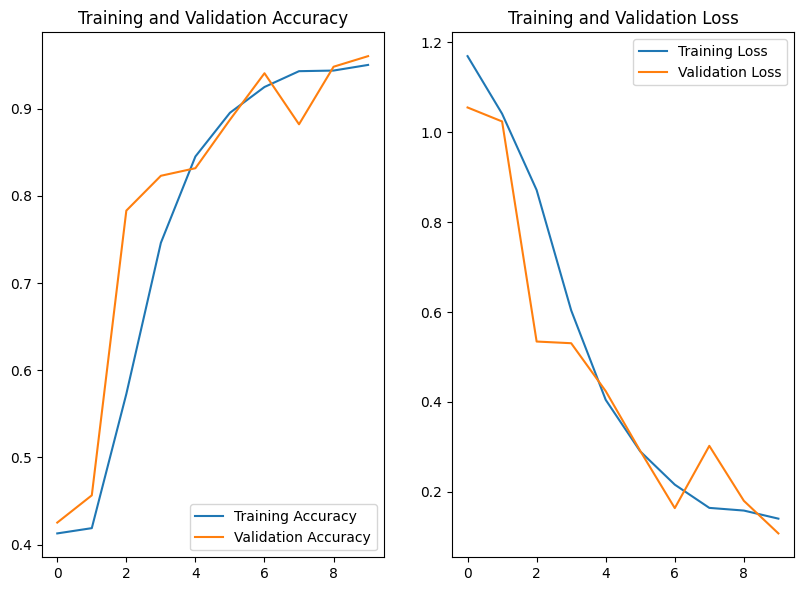

In [22]:
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

### Making predictions using the model

First Image of batch to predict :
Actual label :  Early_Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Predicted label :  Early_Blight
<class 'tensorflow.python.framework.ops.EagerTensor'>


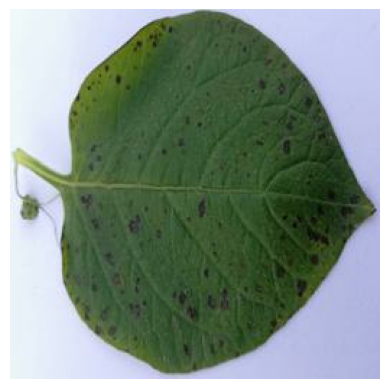

In [25]:
for batch_image, batch_label in test_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')
    print(type(batch_image))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


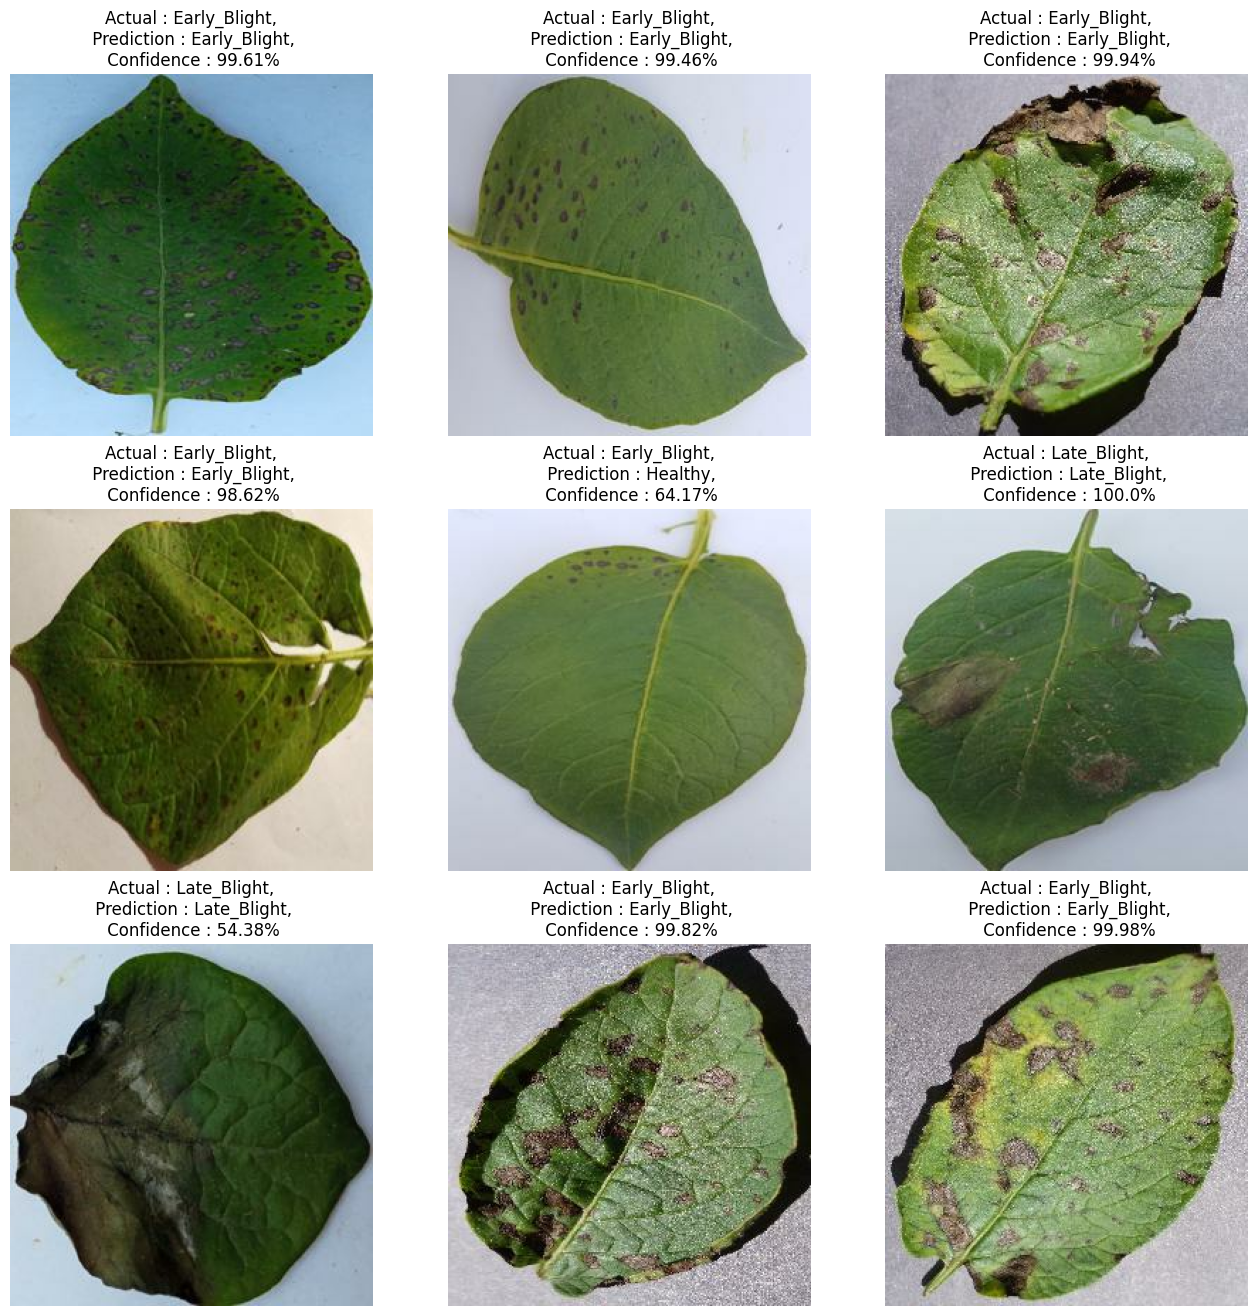

In [24]:
plt.figure(figsize = (16,16))
for batch_image, batch_label in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')